# ML HW2


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# you can choose one of the following package for image reading/processing
# import cv2
from PIL import Image

## 1. Classification Problem


In [2]:
NUM_CLASSES = 10
NUM_DATA_PER_CLASS = 128
FEATURE_SIZE = 28 * 28

train_x, train_t = [], []
test_x, test_t = [], []


def read_image(path):
    with Image.open(path) as img:
        image = np.array(img)
    # map [0, 255.] to [0, 1.]
    return image.reshape(-1) / 255.


def onehot_encoding(label):
    onehot = np.zeros(10)
    onehot[label] = 1
    return onehot


for c in range(NUM_CLASSES):
    data = []
    for i in range(NUM_DATA_PER_CLASS):
        path = os.path.join('MNIST', str(c), f'{i}.jpg')
        image = read_image(path)
        label = onehot_encoding(c)
        data.append((image, label))

    np.random.default_rng().shuffle(data)
    train_x.extend([x for x, _ in data[:96]])
    train_t.extend([t for _, t in data[:96]])
    test_x.extend([x for x, _ in data[96:]])
    test_t.extend([t for _, t in data[96:]])

train_x, train_t = np.array(train_x), np.array(train_t)
test_x, test_t = np.array(test_x), np.array(test_t)

print('train_x.shape:', train_x.shape)
print('train_t.shape:', train_t.shape)
print('test_x.shape:', test_x.shape)
print('test_t.shape:', test_t.shape)


train_x.shape: (960, 784)
train_t.shape: (960, 10)
test_x.shape: (320, 784)
test_t.shape: (320, 10)


### 1.1 Least squares for classification

$$ y(\mathbf{x}) = \widetilde{ \mathbf{W} }^{T} \widetilde{ \mathbf{x} } $$

the sum-of-squares error function is

$$ E_{D}(\widetilde{ \mathbf{W} }) = \frac{1}{2}\text{Tr}\{(\widetilde{ \mathbf{X} }\widetilde{ \mathbf{W} } - \mathbf{T})^{T} (\widetilde{ \mathbf{X} }\widetilde{ \mathbf{W} } - \mathbf{T})\} $$

the optimal solution is

$$ \widetilde{ \mathbf{W} } = (\widetilde{ \mathbf{X} }^{T} \widetilde{ \mathbf{X} })^{-1} \widetilde{ \mathbf{X} }^{T} \mathbf{T} = \widetilde{ \mathbf{X} }^{\dagger} \mathbf{T} $$


In [3]:
def dummy_x(x):
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)


def sum_of_square_error(x, t, w):
    return np.trace((x @ w - t).T @ (x @ w - t)) / 2


def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))


def optimal_weight(x, t):
    return np.linalg.pinv(x) @ t


In [4]:
w = optimal_weight(dummy_x(train_x), train_t)

train_loss = sum_of_square_error(dummy_x(train_x), train_t, w)
train_acc = accuracy(train_t, dummy_x(train_x) @ w)

test_loss = sum_of_square_error(dummy_x(test_x), test_t, w)
test_acc = accuracy(test_t, dummy_x(test_x) @ w)

In [5]:
print(f'train loss: {train_loss}')
print(f'train accuracy: {train_acc}')
print(f'test loss: {test_loss}')
print(f'test accuracy: {test_acc}')

train loss: 26.938078853393854
train accuracy: 1.0
test loss: 1720.035757171112
test accuracy: 0.5


### 1.2 Logistic regression


In [6]:
def split_batch(x, t, batch_size):
    for i in range(0, len(x), batch_size):
        if i + batch_size < len(x):
            yield x[i:i + batch_size], t[i:i + batch_size]
        else:
            yield x[i:], t[i:]


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


def cross_entropy_error(y_true, y_pred, eps=1e-8):
    return -np.sum(y_true * np.log(y_pred + eps))


def gradient(x, t, w):
    return x.T @ (softmax(x @ w) - t)


def gradient_descent(train_x, train_t, test_x, test_t, epochs, lr, batch_size):
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    w = np.zeros((FEATURE_SIZE + 1, NUM_CLASSES))
    for _ in range(epochs):
        for x, t in split_batch(train_x, train_t, batch_size):
            x = dummy_x(x)
            w -= lr * gradient(x, t, w)
        train_loss.append(cross_entropy_error(train_t, softmax(dummy_x(train_x) @ w)))
        train_acc.append(accuracy(train_t, softmax(dummy_x(train_x) @ w)))
        test_loss.append(cross_entropy_error(test_t, softmax(dummy_x(test_x) @ w)))
        test_acc.append(accuracy(test_t, softmax(dummy_x(test_x) @ w)))
    return w, train_loss, train_acc, test_loss, test_acc


def plot_gd(name, train_loss, train_acc, test_loss, test_acc):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(train_acc, label='train acc')
    plt.plot(test_acc, label='test acc')
    plt.legend()
    plt.show()

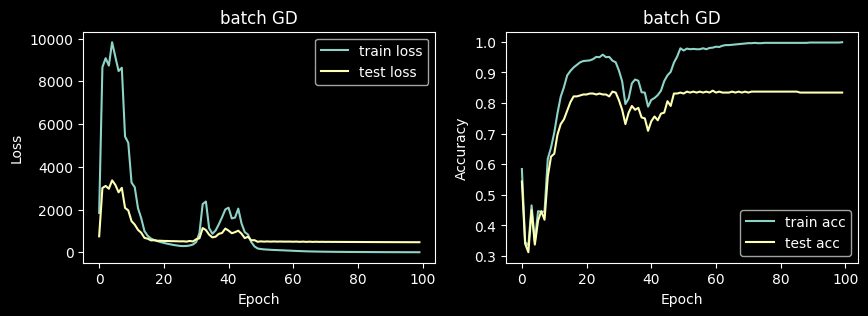

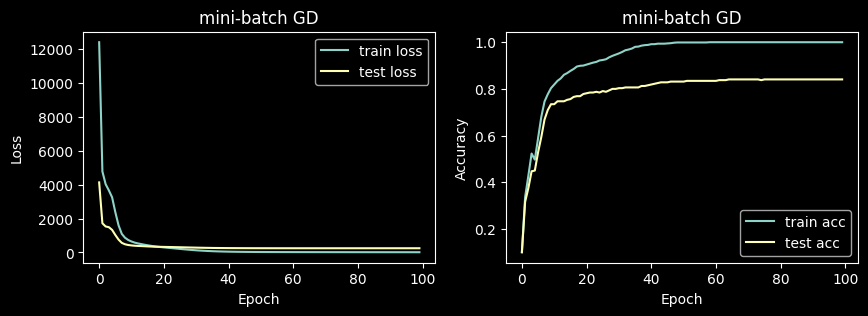

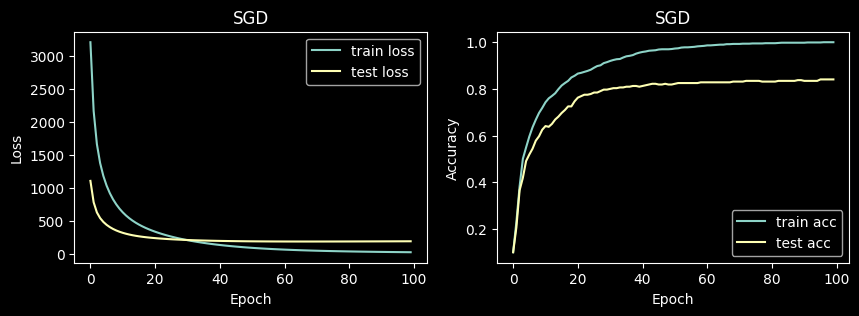

In [7]:
LEARING_RATE = 0.01
BATCH_SIZES = {
    'batch GD': len(train_x),
    'mini-batch GD': 64,
    'SGD': 1,
}

log = {}

for name, batch_size in BATCH_SIZES.items():
    w, train_loss, train_acc, test_loss, test_acc = gradient_descent(train_x,
                                                                     train_t,
                                                                     test_x,
                                                                     test_t,
                                                                     epochs=100,
                                                                     lr=LEARING_RATE,
                                                                     batch_size=batch_size)
    plot_gd(f'{name}', train_loss, train_acc, test_loss, test_acc)
    log[name] = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': test_loss,
        'test_acc': test_acc,
    }

In [8]:
def print_result(name, train_loss, train_acc, test_loss, test_acc):
    print(f'=== {name} ===\n'
          '- train\n'
          f'  - loss: {train_loss[-1]:.4f}\n'
          f'  - acc : {train_acc[-1]:.4f}\n'
          '- test\n'
          f'  - loss: {test_loss[-1]:.4f}\n'
          f'  - acc : {test_acc[-1]:.4f}\n')


for name, result in log.items():
    print_result(name, result['train_loss'], result['train_acc'], result['test_loss'],
                 result['test_acc'])


=== batch GD ===
- train
  - loss: 7.2059
  - acc : 0.9990
- test
  - loss: 475.4743
  - acc : 0.8344

=== mini-batch GD ===
- train
  - loss: 10.2038
  - acc : 1.0000
- test
  - loss: 245.4894
  - acc : 0.8406

=== SGD ===
- train
  - loss: 27.3739
  - acc : 1.0000
- test
  - loss: 193.4031
  - acc : 0.8406



### 1.3 Discussion

All of these three methods converged at similar accuracy in 100 epochs.

- smoothness: `SGD` > `mini-batch GD` > `batch GD`. I think this is bacause the loss of each epoch is the last loss in the epoch. Because `SGD` updates weights the most fequently, the loss is the most smooth.
- overfitting: `batch GD` > `mini-batch GD` > `SGD`. I guess that because `batch GD` uses the whole dataset to update weights, it is more likely to overfit.


## 2. Gaussian Process for Regression


In [9]:
data_x_df = pd.read_csv('gaussian_process/x.csv', header=None, names=['x'])
data_t_df = pd.read_csv('gaussian_process/t.csv', header=None, names=['t'])
data_df = pd.concat([data_x_df, data_t_df], axis=1)
data_df

,x,t
0,4.520904,-7.643232
1,8.877857,2.681281
2,7.085027,3.082743
3,5.681220,-2.845291
4,9.007329,3.751909
...,...,...
295,8.018778,5.956964
296,8.783946,3.181011
297,9.245901,0.717848
298,8.155217,6.622701


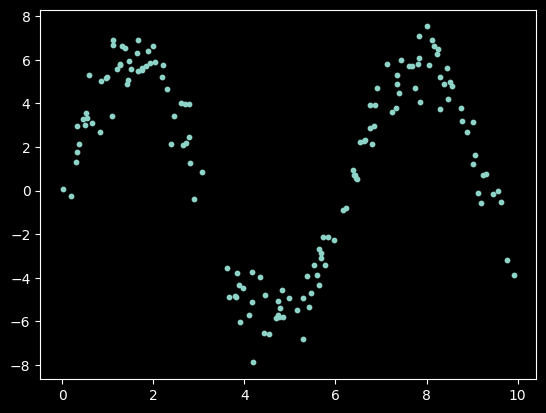

In [10]:
dataset = np.array(data_df)
np.random.default_rng().shuffle(dataset)

train_size = 150
train_x = dataset[:train_size, 0]
train_t = dataset[:train_size, 1]
test_x = dataset[train_size:, 0]
test_t = dataset[train_size:, 1]

plt.scatter(train_x, train_t, s=10)
plt.show()

In [11]:
INV_BETA = 1


def gram_matrix(x, kernel_fn):
    K = np.empty((len(x), len(x)))
    for n in range(len(x)):
        for m in range(len(x)):
            K[n, m] = kernel_fn(x[n], x[m])
    return K


def covariance_matrix(K, inv_beta):
    return K + np.eye(len(K)) * inv_beta


def rms_error(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))


def gaussian_process(test_x, train_x, train_t, kernel_fn, inv_beta, C):
    c = kernel_fn(test_x, test_x) + inv_beta
    k = np.empty(len(train_x))
    for n in range(len(train_x)):
        k[n] = kernel_fn(train_x[n], test_x)

    mean = k.T @ np.linalg.inv(C) @ train_t
    var = c - k.T @ np.linalg.inv(C) @ k
    return mean, var


def plot_gaussian_process(name, train_x, train_t, kernel_fn, inv_beta, C):
    x = np.linspace(0, 10, 100)
    y = np.empty_like(x)
    var = np.empty_like(x)

    for i in range(len(x)):
        y[i], var[i] = gaussian_process(x[i], train_x, train_t, kernel_fn, inv_beta, C)

    plt.figure(figsize=(5, 3))
    plt.title(name)
    plt.scatter(train_x, train_t, s=10)
    plt.plot(x, y)
    plt.fill_between(x, y - np.sqrt(var), y + np.sqrt(var), alpha=0.3)
    plt.show()

### 2.1 Polynomial kernel function


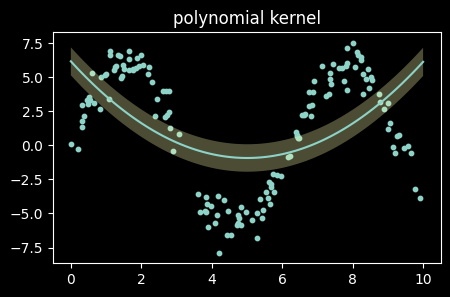

train error: 3.6871051612246193
test error: 4.103162038818357


In [12]:
def poly_kernel(x_n, x_m, m=2):
    phi_x_n = np.array([x_n**i for i in range(m + 1)])
    phi_x_m = np.array([x_m**i for i in range(m + 1)])
    return phi_x_n.T @ phi_x_m


K = gram_matrix(train_x, poly_kernel)
C = covariance_matrix(K, INV_BETA)

plot_gaussian_process('polynomial kernel', train_x, train_t, poly_kernel, INV_BETA, C)

train_t_pred = np.empty_like(train_t)
for i in range(len(train_t_pred)):
    train_t_pred[i], _ = gaussian_process(train_x[i], train_x, train_t, poly_kernel, INV_BETA, C)

print(f'train error: {rms_error(train_t, train_t_pred)}')

test_t_pred = np.empty_like(test_t)
for i in range(len(test_t_pred)):
    test_t_pred[i], _ = gaussian_process(test_x[i], train_x, train_t, poly_kernel, INV_BETA, C)

print(f'test error: {rms_error(test_t, test_t_pred)}')

### 2.2 Exponential-quadratic kernel function


theta: (0, 0, 0, 1)


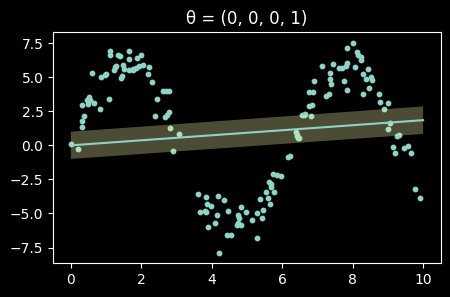

train error: 4.372392258668127
test error: 4.351268840473354

theta: (1, 1, 0, 0)


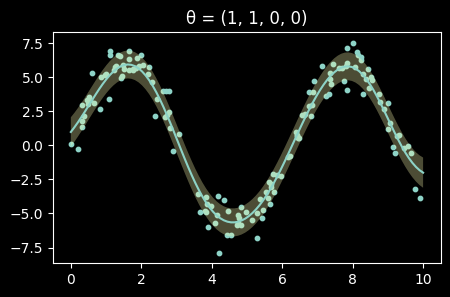

train error: 0.9081852450434813
test error: 1.0032427498282586

theta: (1, 1, 0, 16)


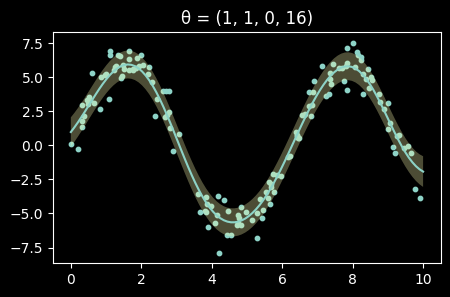

train error: 0.9093257444111783
test error: 1.0037580304255191

theta: (1, 2, 16, 0)


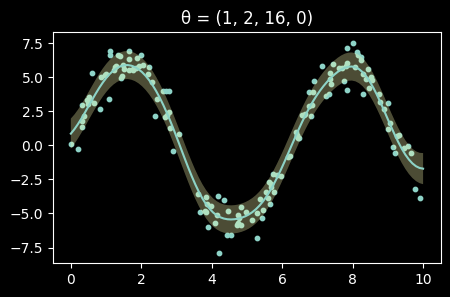

train error: 0.8955604351776996
test error: 1.018901454871097



In [13]:
THETA = [
    (0, 0, 0, 1),
    (1, 1, 0, 0),
    (1, 1, 0, 16),
    (1, 2, 16, 0),
]


def exponential_quadratic_kernel(x_n, x_m, theta_0, theta_1, theta_2, theta_3):
    return theta_0 * np.exp(-theta_1 / 2 * np.sum((x_n - x_m)**2)) + theta_2 + theta_3 * x_n.T * x_m


for theta in THETA:
    print(f'theta: {theta}')
    kernel_fn = lambda x_n, x_m: exponential_quadratic_kernel(x_n, x_m, *theta)
    K = gram_matrix(train_x, kernel_fn)
    C = covariance_matrix(K, INV_BETA)

    plot_gaussian_process(f'θ = {theta}', train_x, train_t, kernel_fn, INV_BETA, C)

    train_t_pred = np.empty_like(train_t)
    for i in range(len(train_t_pred)):
        train_t_pred[i], _ = gaussian_process(train_x[i], train_x, train_t, kernel_fn, INV_BETA, C)

    print(f'train error: {rms_error(train_t, train_t_pred)}')

    test_t_pred = np.empty_like(test_t)
    for i in range(len(test_t_pred)):
        test_t_pred[i], _ = gaussian_process(test_x[i], train_x, train_t, kernel_fn, INV_BETA, C)

    print(f'test error: {rms_error(test_t, test_t_pred)}')
    print()


### 2.3 Automatic relevance determination


In [14]:
def dtheta_0(theta_1, x):
    d = np.empty((len(x), len(x)))
    for n in range(len(x)):
        for m in range(len(x)):
            d[n, m] = np.exp(-theta_1 / 2 * np.sum((x[n] - x[m])**2))
    return d


def dtheta_1(theta_1, x):
    d = np.empty((len(x), len(x)))
    for n in range(len(x)):
        for m in range(len(x)):
            x_term = np.sum((x[n] - x[m])**2)
            d[n, m] = -1 / 2 * np.exp(-theta_1 / 2 * x_term) * x_term
    return d


def dtheta_2(x):
    return np.ones((len(x), len(x)))


def dtheta_3(x):
    d = np.empty((len(x), len(x)))
    for n in range(len(x)):
        for m in range(len(x)):
            d[n, m] = x[n] * x[m]
    return d


def dloglikelihood(C, t, dtheta):
    return (-np.trace(np.linalg.inv(C) @ dtheta) +
            t.T @ np.linalg.inv(C) @ dtheta @ np.linalg.inv(C) @ t) / 2


theta: [2.55417158 1.06193371 0.99618707 0.95013087]


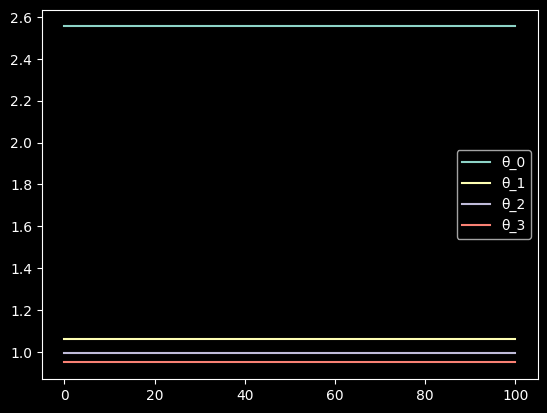

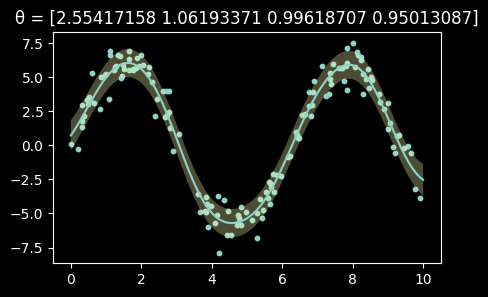

train error: 0.8743441090787512
test error: 0.9877124317100798



In [15]:
EPOCHS = 100
LEARNING_RATE = 0.001

theta = np.array([1.0, 1.0, 1.0, 1.0])
theta_log = [theta]

for epoch in range(EPOCHS):
    kernel_fn = lambda x_n, x_m: exponential_quadratic_kernel(x_n, x_m, *theta)
    K = gram_matrix(train_x, kernel_fn)
    C = covariance_matrix(K, INV_BETA)

    dtheta = np.array([
        dloglikelihood(C, train_t, dtheta_0(theta[1], train_x)),
        dloglikelihood(C, train_t, dtheta_1(theta[1], train_x)),
        dloglikelihood(C, train_t, dtheta_2(train_x)),
        dloglikelihood(C, train_t, dtheta_3(train_x)),
    ])

    theta += LEARNING_RATE * dtheta
    theta_log.append(theta)

print(f'theta: {theta}')
plt.plot(theta_log)
plt.legend(['θ_0', 'θ_1', 'θ_2', 'θ_3'])
plt.show()

kernel_fn = lambda x_n, x_m: exponential_quadratic_kernel(x_n, x_m, *theta)
K = gram_matrix(train_x, kernel_fn)
C = covariance_matrix(K, INV_BETA)

plot_gaussian_process(f'θ = {theta}', train_x, train_t, kernel_fn, INV_BETA, C)

train_t_pred = np.empty_like(train_t)
for i in range(len(train_t_pred)):
    train_t_pred[i], _ = gaussian_process(train_x[i], train_x, train_t, kernel_fn, INV_BETA, C)

print(f'train error: {rms_error(train_t, train_t_pred)}')

test_t_pred = np.empty_like(test_t)
for i in range(len(test_t_pred)):
    test_t_pred[i], _ = gaussian_process(test_x[i], train_x, train_t, kernel_fn, INV_BETA, C)

print(f'test error: {rms_error(test_t, test_t_pred)}')
print()


### 2.4 Discussion

From the five kernel function above, it is apparently that those function with exponential term converge to the similar result and fit the data well.
By using the automatic relevance determination, I obtained a theta `(2.55417158 1.06193371 0.99618707 0.95013087)` which performs better on the training set and the test set.
